In [46]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.datasets import mnist

# 1. multinomial logistic regression with mnist data

In [47]:
mnist.load_data()
mnist = input_data.read_data_sets("./data", one_hot=True)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [44]:
learning_rate = 0.09
training_epochs = 20
batch_size = 80
display_step = 1

# mnist data image of shape 28*28=784
# 0 - 9 recognition -> 10 classes
x = tf.placeholder(tf.float32, [None, 784]) 
y = tf.placeholder(tf.float32, [None, 10])


W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# softmax model
pred = tf.nn.softmax(tf.matmul(x, W) + b) 

# using cross entropy
# use gradient descent
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)


init = tf.global_variables_initializer()


with tf.Session() as sess:


    sess.run(init)


    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs,
                                                          y: batch_ys})
            avg_cost += c / total_batch
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print("Finished!")

    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))

Epoch: 0001 cost= 0.532864098
Epoch: 0002 cost= 0.361025149
Epoch: 0003 cost= 0.330213694
Epoch: 0004 cost= 0.316047758
Epoch: 0005 cost= 0.308028520
Epoch: 0006 cost= 0.301304304
Epoch: 0007 cost= 0.294422028
Epoch: 0008 cost= 0.291574168
Epoch: 0009 cost= 0.286512886
Epoch: 0010 cost= 0.288759521
Epoch: 0011 cost= 0.278943424
Epoch: 0012 cost= 0.281038634
Epoch: 0013 cost= 0.278534079
Epoch: 0014 cost= 0.275540369
Epoch: 0015 cost= 0.276986441
Epoch: 0016 cost= 0.272276273
Epoch: 0017 cost= 0.271651880
Epoch: 0018 cost= 0.270200381
Epoch: 0019 cost= 0.270604570
Epoch: 0020 cost= 0.268859776
Finished!
Accuracy: 0.925


# 2. CNN

In [54]:
mnist = input_data.read_data_sets("./data", one_hot=False)
learning_rate = 0.001
num_steps = 2000
batch_size = 128

num_input = 784 
num_classes = 10 
dropout = 0.3


# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    with tf.variable_scope('ConvNet', reuse=reuse):
        x = x_dict['images']

        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # 32 filters and 5 kernels in Convolution Layer
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # 64 filters and 3 kernels in Convolution Layer2
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        fc1 = tf.contrib.layers.flatten(conv2)

        fc1 = tf.layers.dense(fc1, 1024)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        out = tf.layers.dense(fc1, n_classes)

    return out


def model_fn(features, labels, mode):
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)

    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)


    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)


    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())


    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)


    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs


model = tf.estimator.Estimator(model_fn)


input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

model.train(input_fn, steps=num_steps)


input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
e = model.evaluate(input_fn)

print("Testing Accuracy:", e['accuracy'])

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/sd/0bh7qhmx51x3j987njckxmhm0000gn/T/tmpnwjhrtja', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12d870290>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_mast

# 3. Cell Image Classification

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Define Line Width and Font Size of Plots
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.size'] = 6.0
plt.rcParams['axes.titlesize'] = 6.0

In [59]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


ValueError: Asked to retrieve element 0, but the Sequence has length 0

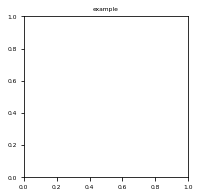

In [72]:
img_size = 72
batch_size = 20

training_set = train_datagen.flow_from_directory('./training',
                                                 target_size = (img_size, img_size),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb')
 
test_set = test_datagen.flow_from_directory('./test',
                                            target_size = (img_size, img_size),
                                            batch_size = batch_size,
                                            class_mode = 'binary',
                                            color_mode = 'rgb')
